<a href="https://colab.research.google.com/github/Bsvelandiac/TSIA206/blob/master/PW1_GabrielaBITTENCOURT_and_BrayamVELANDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_____
<h1><center><b>Spectral and temporal modifications Lab</b></center></h1> 
<h5><center><b>BITTENCOURT Gabriela and VELANDIA Brayam</b></center></h5> 

______
Template from *From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*, python version : 3.6


**Keywords:**  Analysis marks, Spectral scales
, Temporal scales, Signal synthesis. 

**Abstract:** <p align=Justify>In this report, we present the results of PSOLA method implementation for the analysis and synthesis of speech signals.This method is used to modify the pitch and duration of a speech signal.First, we extract the analysis marks of the audio signal provided. Second, we present the functions for the synthesis and modification of the temporal and spectral scales. Finally, we discuss the results obtained.


#**Introduction**

<p align=Justify>Pitch Synchronous Overlap and Add  or PSOLA is a digital signal processing technique used for speech processing. This technique allows, among other things, to make changes of the evolution of the instantaneous frequency and duration of the signal. This technique is used in many speech applications where it is required the ability to modify the fundamental frequency. It is closely familiar to the overlap-add method used in the short-time Fourier transform algorithm. Between the applications of this method we found auto-tune and voice conversion. The general idea is to decompose the audio into individual pitch periods, in that way, we can move the pitch-period to change the effective length. That is, the fundamental frequency of a signal is expressed as a periodic structure of the time-signal.

The PSOLA algorithm is divided into three main steps:



1.   Labelling of periods on the original signal and cutting into short analysis frames synchronized on the pitch.
2.   Temporal reorganisation of pitch and association of one analysis frame with each marker synthesis in order to modify the duration of the signal.
3.   Re-synthesis by addition/overlapping (overlap-add) of the synthesis frames.






In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio

In [4]:
# All the functions provided are in functions_PW1.py
from functions_PW1 import load_sound, play_sound, plot_sound, nextpow2, period 
import os, sys, wave, struct
import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from math import ceil
from math import floor
from scipy import signal
from scipy.io.wavfile import write
from IPython.display import Audio

______
## **Reading and playing .wav file**

Here we test the basic audio functions in order to define some variables of the audio signal used in the practical work.

In [5]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

**Using wave**

In [ ]:
wavefile = load_sound(sound)
print(wavefile.getparams())

In [7]:
Audio(sound)

In [8]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
s = np.array(data)

In [9]:
timestep = 1/float(Fs)
times = np.arange(len(s))*timestep

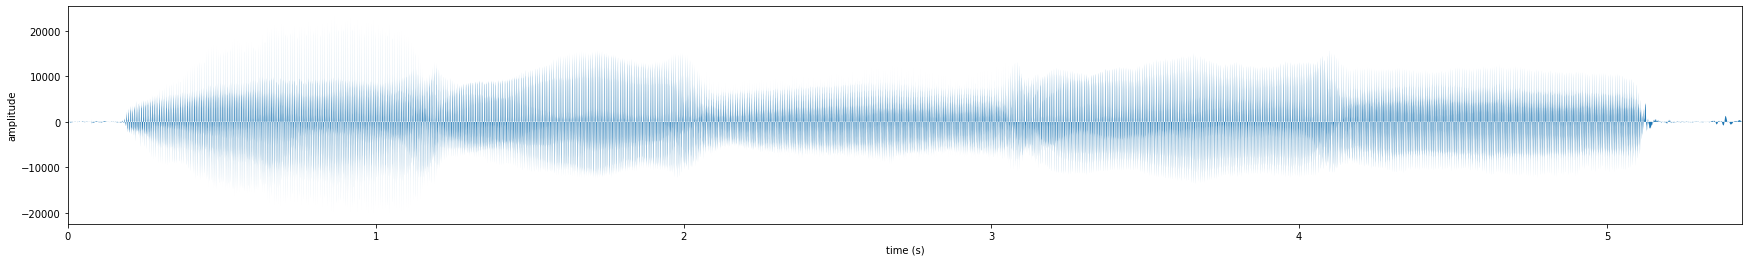

In [10]:
plot_sound(s, times)

In [21]:
def write_n_play_sound(filename, x) :
    write(filename, Fs, np.array(np.real(x), dtype=np.int16))
    sound = os.path.join(data_path, filename)
    Audio(sound)

_____
# **1 - Extraction of the analysis marks**

In this part we will implement the function AnalysysPitchMarks in order to extract the analysis marks. The idea is to create a matrix that contain the times and pitches corresponding to each analysis mark. First, we extract the sequence $x$ that  starts at time $t_a(n-1)$ with duration $2.5P_a(n-1)$. In this sequence we compute the pitch $P_a(n)$ and the $voiced(n)$ with the function period provided. We repeat changing $t_a(n)=t_a(n-1)+P_a(n)$. 

In [ ]:
period(s, Fs)

In [13]:
def AnalysisPichMarks(s, Fs) :
    
    ta = np.array([0])
    Pa = np.ceil(np.array([0.01*Fs])).astype(int)
    voiced = np.array([0])
    
    while ( ta[-1]+2.5*Pa[-1] <= len(s) ) : # while there are frames
        
        # Extracting x -> start: ta(n-1), duration: 2.5*Pa(n-1)
        t0 = int(ta[-1])
        tf = int(ta[-1] + 2.5*Pa[-1])
        x = s[t0:tf]
        
        # Computation Pa(n) and voiced(n)
        Pa     = np.append(Pa,   period(x, Fs)[0])
        voiced = np.append(voiced,period(x, Fs)[1])
        
        # Computation ta(n)
        ta = np.append(ta, ta[-1]+Pa[-1])

    A = np.array(([ta, voiced, Pa])).astype(int)
    return A

# A(0,:) = ta(n)
# A(1,:) = voiced(n)
# A(2,:) = Pa(n)
A = AnalysisPichMarks(s, Fs)

The final result, a matrix of dimension 3x706. Where the first column is thetime corresponding to each analysis mark. The second is a boolean that indicates if the signal is voiced or unvoiced and the third one describes the pitch.

In [65]:
A.shape

(3, 706)

_____
# **2 - Synthesis and modification of the temporal and spectral scales**

Here we create the matrix B that contains the index of the analysis mark corresponding to this same synthesis mark. 

In [67]:
B = np.array([A[0], np.arange(A.shape[1])])

_____
## **2.1 - Signal Synthesis**

Now, we want to compute recursively the synthesis signal $y$ from the original signal $s$, the sampling frecuency $F_s$ and the matrix A and B. 

In [16]:
def Synthesis(s, Fs, A, B) :
    
    # filter ta(A[0]), Pa(A[2]) to only the indices in n[k](B[1])
    ta_filter = A[0][B[1]]
    Pa_filter = A[2][B[1]]
    ts = B[0]
    
    # initialize y
    y = np.zeros(ts[-1] + Pa_filter[-1])
    
    for k in range(1,B.shape[1]):
        # extraction of x
        x = s[ ta_filter[k]-Pa_filter[k] : ta_filter[k]+Pa_filter[k]]
        # Hann window
        ws = signal.windows.hann(2*Pa_filter[k])
        # overlap-add
        y[ts[k]-Pa_filter[k] : ts[k]+Pa_filter[k]] += x*ws
    
    return y

y = Synthesis(s, Fs, A, B)

The function Synthesis implement windowing of $x$ by a Hann window. This function is a member of both the cosine-sum and power-of-sine families. Then, we overalap-add the sequence x windowed on  $y(t_s(k) − P_a(n(k)) : t_s(k) + P_a(n(k)))$. This allow us to shift their positions as desired and then add them back together. As we did before, we extract the secuence $x$ this time with length $2P_a(n(k))+1$. As a result we obtain the perfect reconstruction showed below.

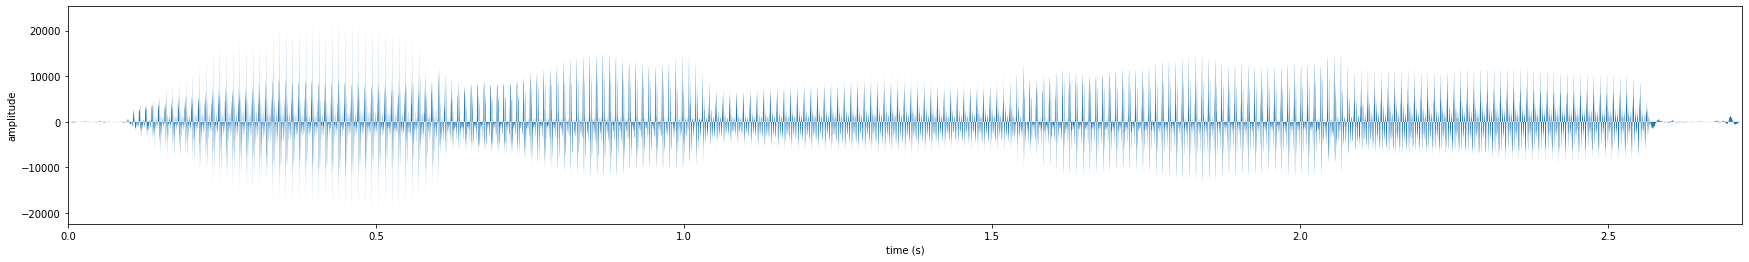

In [68]:
times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('perfect_reconstruction.wav', y)

In [23]:
Audio("perfect_reconstruction.wav")

Here we show the spectogram in order to see the  spectrum of frequencies of the signal as it varies with time. 

timebins:  117
freqbins:  513


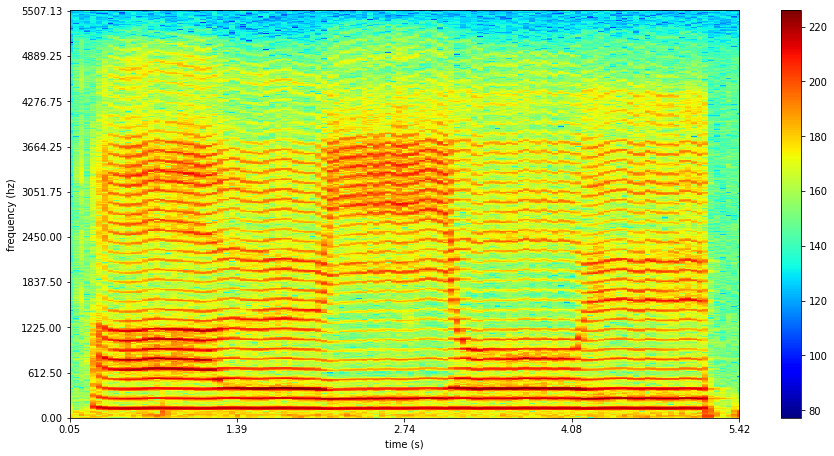

<Figure size 432x288 with 0 Axes>

In [56]:
ims = plotstft("perfect_reconstruction.wav")

_____
## **2.2 - Modification of the temporal scale**

Sometimes when we create temporal scale in speech signal, the transformation creates some not desired effects in the voice. With the temporal scale by the synthesis marks we can avoid this effects. The general idea is to compute the matrix B from the factor $\alpha$, the analysis marks in A and the sampling frecuency $F_s$.

In [24]:
def ChangeTimeScale(alpha,A,Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    while(floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + A[2][floor(n[-1])])
        n  = np.append(n, n[-1]+1/alpha)
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

The matrix B will be formed by two columns with the respective values  $t_s(k) = t_s(k − 1) + P_a(n(k))$ and $n(k + 1) = n(k) + \frac{1}{\alpha}$. In this way we obtain the process of changing the speed or duration of an audio signal without affecting its pitch. Here we represent Time streching and Time compressing as an example.

### **Time streching**

For the time streching we use a factor $\alpha=1.5$

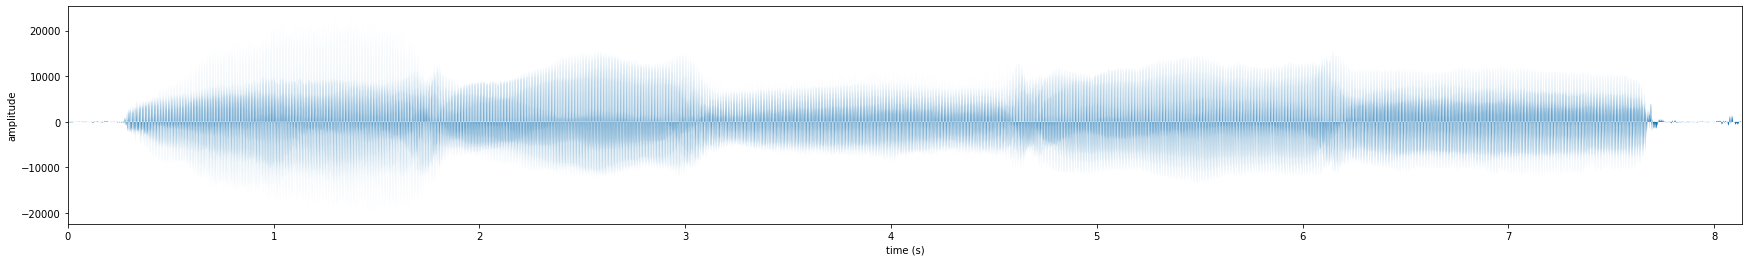

In [25]:
# time streching by 1.5
alpha = 1.5

B = ChangeTimeScale(alpha,A,Fs)
y = Synthesis(s, Fs, A, B)
times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_stretching.wav', y)

In [27]:
Audio('time_stretching.wav')

timebins:  176
freqbins:  513


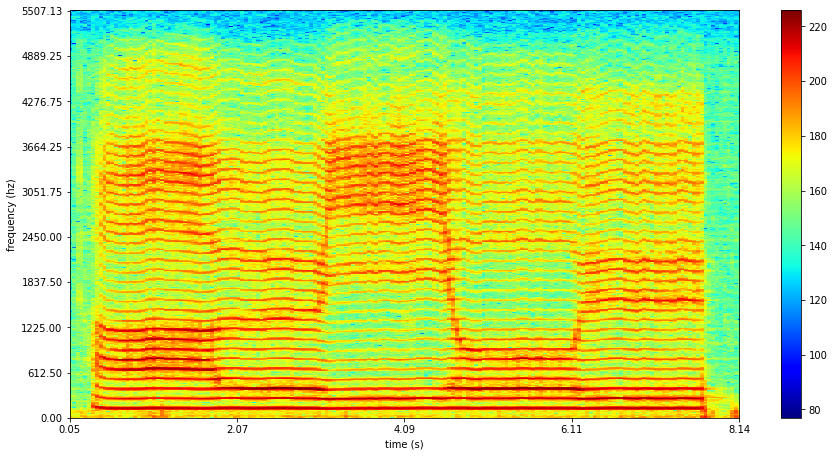

<Figure size 432x288 with 0 Axes>

In [58]:
ims = plotstft("time_stretching.wav")

### **Time compressing**

For the time compressing we use a factor $\alpha=0.5$

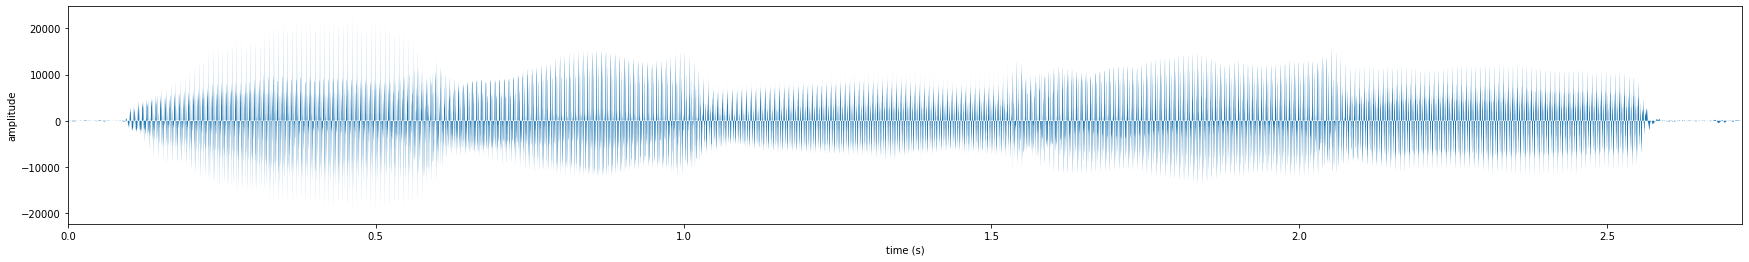

In [29]:
# time compressing by 0.5
alpha = 0.5

B = ChangeTimeScale(alpha,A,Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_compressing.wav', y)

In [30]:
Audio('time_compressing.wav')

timebins:  59
freqbins:  513


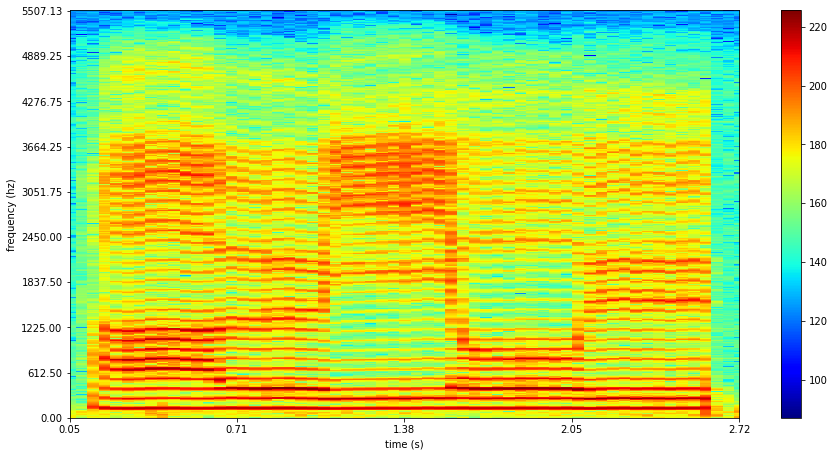

<Figure size 432x288 with 0 Axes>

In [59]:
ims = plotstft("time_compressing.wav")

As we explain before, this achieves a very good quality modification of the time scale without resampling the signal. The goal with Time Scale Modification is speeding up or slowing down a sound without affecting the frequency content, such as the perceived pitch of any tonal components. In the previous results, the time scaling of the speech sound like the speaker talking at a slower or faster pace, without distortion of the spoken vowels. 

______
## **2.3 - Modification of the spectral scale**

Now, we implement the dual operation of the time scaling but in order to change the tone of the voice. First, we determine the synthesis marks that will modify the spectral scale by a factor $\beta$ with the function Change Pitch Scale. 

In [31]:
def ChangePitchScale(beta, A, Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    scale = A[1]/beta
    scale[scale == 0] = 1
    
    while (floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + scale[floor(n[-1])] * A[2][floor(n[-1])])
        n  = np.append(n, n[-1] + scale[floor(n[-1])])
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

In this function, we compute the matrix B with the analysis marks stocked in A and the sampling frecuency $F_s$. We differenciate between the voiced and unvoiced cases. If the analysis mark is voiced we set the scale to $\frac{1}{\beta}$, otherwise the scale is 1. 

### **Pitch increasing**

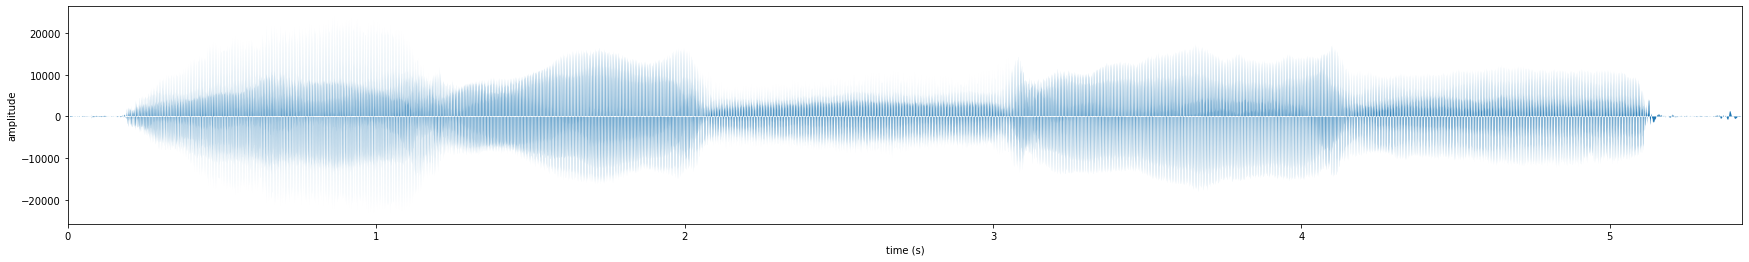

In [32]:
# pitch increasing
beta = 1.5

B = ChangePitchScale(beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('pitch_increase.wav', y)

In [33]:
Audio('pitch_increase.wav')

timebins:  117
freqbins:  513


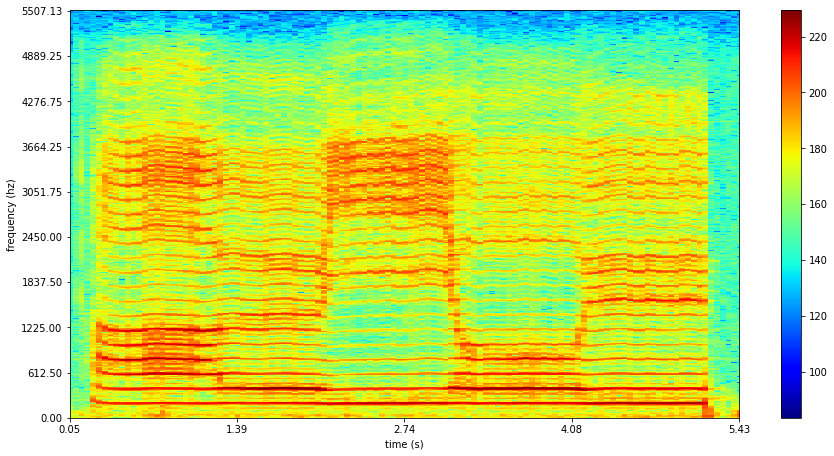

<Figure size 432x288 with 0 Axes>

In [60]:
ims = plotstft("pitch_increase.wav")

### **Pitch decreasing**

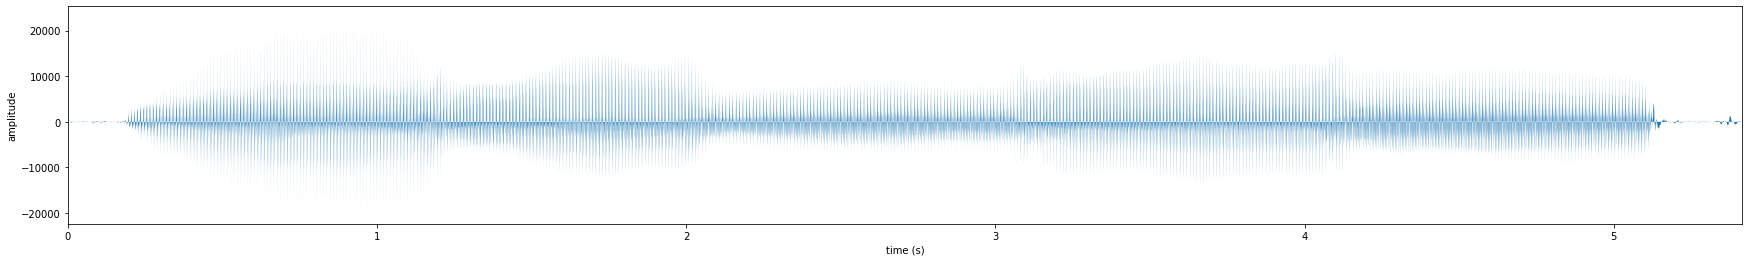

In [34]:
# pitch decreasing
beta = 0.7

B = ChangePitchScale(beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('pitch_decrease.wav', y)

In [35]:
Audio('pitch_decrease.wav')

timebins:  117
freqbins:  513


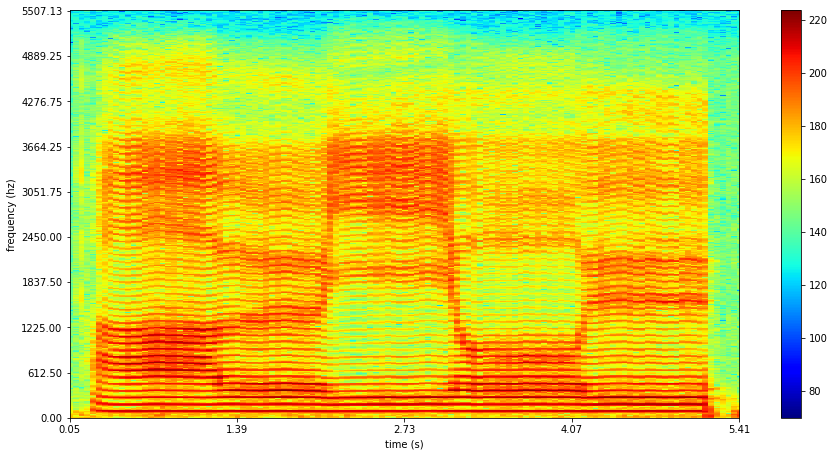

<Figure size 432x288 with 0 Axes>

In [61]:
ims = plotstft("pitch_decrease.wav")

______
## **2.4 - Joint modification of the temporal and spectral scales**

Finally, we implement a function that jointly modify both scales with the same arguments as before.

In [36]:
def ChangeBothScales(alpha,beta,A,Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    scale = A[1]/beta
    scale[scale == 0] = 1
    
    while (floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + scale[floor(n[-1])] * A[2][floor(n[-1])])
        n  = np.append(n, n[-1] + scale[floor(n[-1])]/alpha)
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

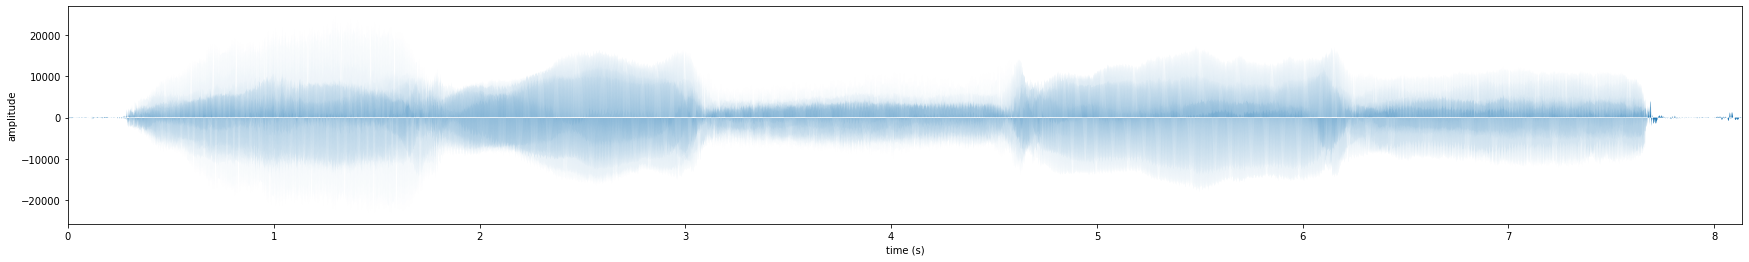

In [37]:
# time stretching and pitch increasing
alpha = 1.5
beta = 1.5

B = ChangeBothScales(alpha, beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_n_frequency_scale1.wav', y)

In [38]:
Audio('time_n_frequency_scale1.wav')

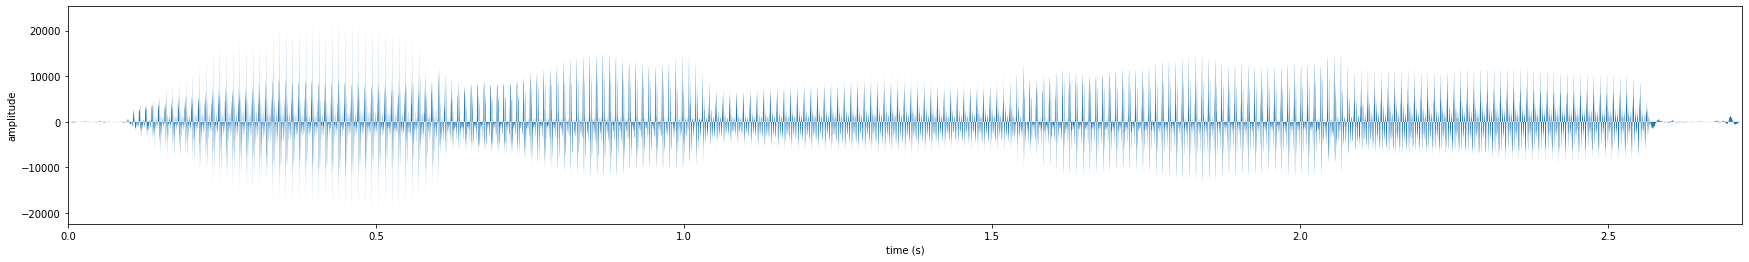

In [39]:
# time compressing and pitch decreasing
alpha = 0.5
beta = 0.7

B = ChangeBothScales(alpha, beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_n_frequency_scale2.wav', y)

In [40]:
Audio('time_n_frequency_scale2.wav')

timebins:  59
freqbins:  513


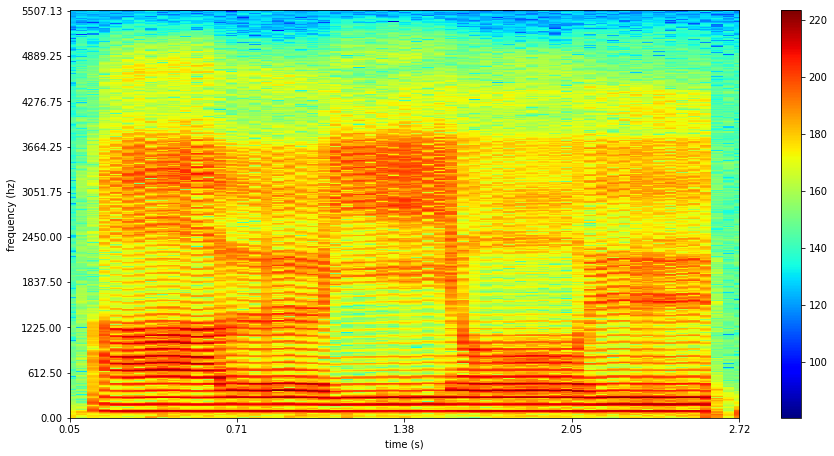

<Figure size 432x288 with 0 Axes>

In [55]:
ims = plotstft("time_n_frequency_scale2.wav")

# **Conclusions**



*   One of the advantage of PSOLA method is that we can change the pitch directly based in the rate space between analysis marks, keeping formants intacts. In this way we avoid the process of changing the pitch that we do not  need, making the time scale and resampling after.
*   In PSOLA we need a really powerfull pitch detection method. As we saw before, this is the basis of the time and spectral scaling. For some audio signals this is not that easy, specially when the source has noise. In this cases we need to considerate other methods in order to change the audio properly.
*   This audio processing methods allow us to speed up or slow down a sound without affecting the frequency content, such as the perceived pitch of any tonal components. In the signal we changed bedore, we obtain an audio output without distortion of the spoken vowels, the time scaling of the speech sound like the speaker talking at a slower or faster pace.




